# Model Evaluation for the Hydride Challenge

In this notebook, we'll apply my **`Regressor`** class to evaluate regression models on the hydride dataset. See `modeling.py` for the code and docstrings (it is well-commented). A `Regressor` takes two arguments:
* An instance of a sklearn estimator
* A name for the model

And it has a few important methods:
* **`evaluate()`**: takes features (X) and targets (y), and measures a variety of performance metrics over the specified type of cross validation, optionally shuffling and standardizing the data, returning a DataFrame with model performance metrics for both training and validation.
* **`parity_plot()`**: takes features (X) and targets (y), fits the model and plots predictions vs. ground truths for both training and validation on a single plot
* **`optimize_hyperparameters()`**: advanced method... uses Facebook's [nevergrad](https://github.com/facebookresearch/nevergrad) library to do a mixed continuous/discrete "grid search" on hyperparameters. Need to instrument the HP variables you want to vary first.

# Imports and MPL aesthetics

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
from data_utils import *
from modeling import *

from sklearn import metrics, linear_model, ensemble, \
preprocessing, model_selection, neural_network, neighbors, gaussian_process
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('seaborn')
rcParams.update({'figure.autolayout': True,
                 'xtick.top': True,
                 'xtick.direction': 'in',
                 'ytick.right': True,
                 'ytick.direction': 'in',
                 'font.sans-serif': 'Arial',
                 'font.size': 20,
                 'savefig.dpi': 300,
                 'figure.dpi': 96
                })

/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# Table of Contents <a name="contents"></a>
---

## [0. Model Exploration](#models)
> ### [0.0 Re-Loading Data](#load)
> ### [0.1 Evaluating a Model](#eval)
> ### [0.2 Evaluating Many Models](#para)

## [1. Feature Selection](#feats)
> ### [1.0 Feature Importances](#imp)
> ### [1.1 Recursive Feature Elimination](#rfe)
> ### [1.2 Random Feature Elimination](#rand)


## [2. Hyperparameter Optimization](#hypes)

# 0. Model Exploration <a name="models"></a>

## 0.0 Reload the data from where we left off <a name="load"></a>
---
[Back to TOC](#contents)

This uses the `load_clean()` and `featurize()` functions we built and stuffed in `data_utils.py`.

In [2]:
df = load_clean()
X = featurize(df)
y = df['Heat of Formation (kJ/mol H2)'].astype(float)
df.sample(3)

Widget Javascript not detected.  It may not be installed or enabled properly.


,Material Class,Composition Formula,Hydrogen Weight Percent,Heat of Formation (kJ/mol H2),Temperature (˚C),Pressure (Atmospheres Absolute),Author Year,Reference Number,Comment1,Comment2,Comment3,clean_composition,composition
574,AB2,ZrFe1.4Cr.6,1.5,29.9,20,3,"Ivey, 1984",29,NaN,NaN,NaN,ZrFe1.4Cr.6,"(Zr, Fe, Cr)"
1075,AB5,LaNi4.8Sn.2,1.4,29.4,25,0.8,"Zhang, 1996",679,NaN,NaN,NaN,LaNi4.8Sn.2,"(La, Ni, Sn)"
823,AB2,TiMn1.4Ni.1,NaN,28,0,2,"Andreev, 1984",684,NaN,NaN,NaN,TiMn1.4Ni.1,"(Ti, Mn, Ni)"


### Similarly, load the test data

In [3]:
X_test, df_test = load_test_data(X, standardize=False)
X_test.sample(3)

Widget Javascript not detected.  It may not be installed or enabled properly.


,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
8,22.0,26.0,4.0,24.00000,2.000000,22.0,43.0,55.0,12.0,49.000000,...,2.110640,1.055343,1.055320,0.000023,194.0,229.0,35.0,211.500000,17.500000,194.0
32,22.0,40.0,18.0,24.83871,2.101977,25.0,43.0,52.0,9.0,48.096774,...,0.000310,0.000147,0.000148,0.000310,194.0,229.0,35.0,211.161290,12.178980,217.0
5,22.0,26.0,4.0,23.60000,1.066667,24.0,43.0,55.0,12.0,47.800000,...,2.110663,0.211094,0.379914,0.000000,194.0,229.0,35.0,216.533333,15.022222,229.0


Print out the shapes just to make sure everything looks right.

In [4]:
print('Main frame size: {}\n'.format(df.shape),
      'test frame size: {}\n'.format(df_test.shape),
      'Feature Array size: {}\n'.format(X.shape),
      'Test Features size: {}'.format(X_test.shape))

Main frame size: (542, 13)
 test frame size: (50, 8)
 Feature Array size: (542, 132)
 Test Features size: (50, 132)


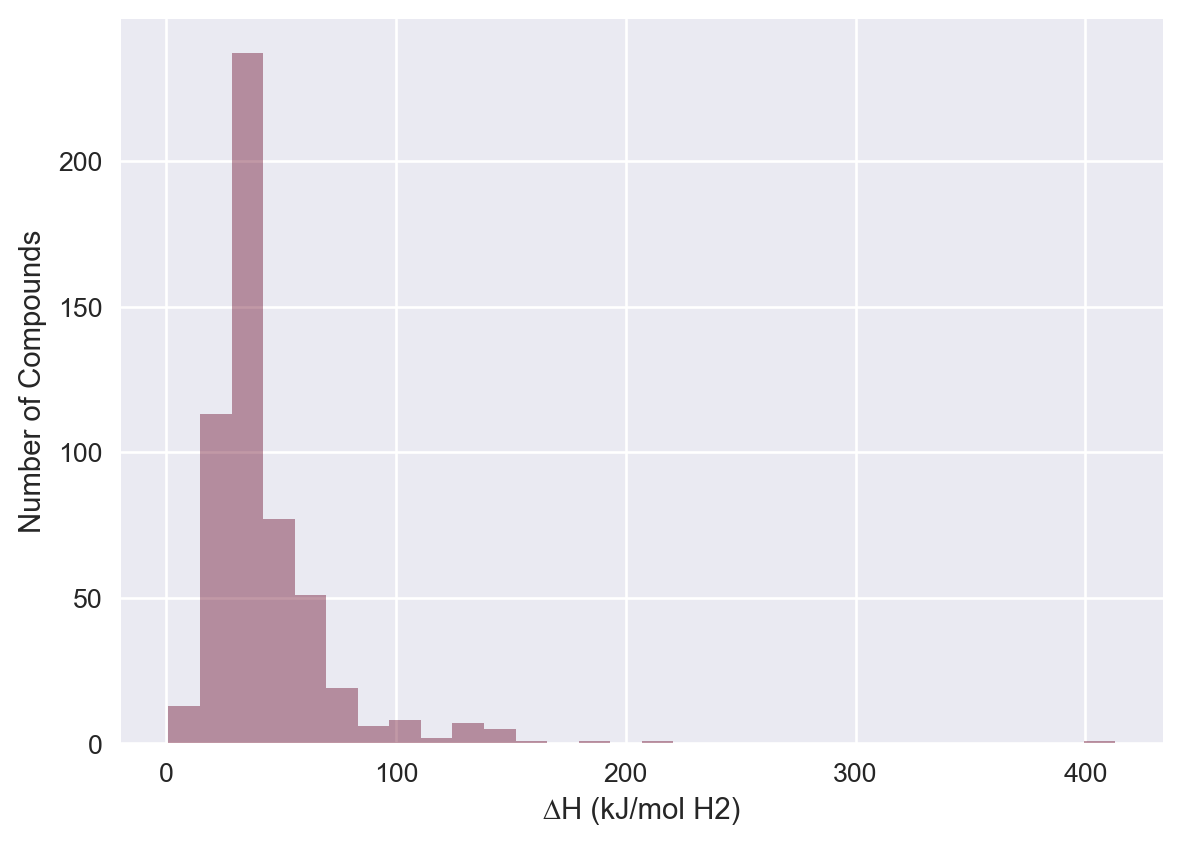

In [5]:
plt.figure(figsize=(7,5), tight_layout=False)
sns.distplot(y, bins=30, color='xkcd:maroon', kde=False)
plt.xlabel('∆H (kJ/mol H2)');
plt.ylabel('Number of Compounds');
plt.savefig('figures/H_histogram_full_dataset.png')

# 0.1 Evaluating a model <a name="eval"></a>
---
[Back to TOC](#contents)

Here, we will instantiate a `Regressor` with a RandomForestRegressor from sklearn, and evaluate it with 5-fold CV, shuffling and standardization.

In [6]:
rf_reg = Regressor(ensemble.RandomForestRegressor(), name='Random Forest')
scores = rf_reg.evaluate(X, y, shuffle=True, n_splits=5)
scores

train                                            val                    \
       mae     mape   medape   pearson  spearman      mae     mape   medape   
0  4.44166  12.6575     5.32  0.953409  0.936655  9.21576  22.6928  9.49365   
1  4.14982  9.66212  5.45935  0.944668  0.959487  12.6697  55.7161  14.7926   
2  4.13897  11.5707  5.12942  0.960259  0.947126  10.1424  20.9111  13.0633   
3  4.52585  13.9382  5.17128  0.952643   0.93285  6.96502   20.121  10.9912   
4  4.46866  11.9191  5.55307  0.961791  0.941065  6.93714  17.1508  9.79878   

                       
    pearson  spearman  
0  0.775005  0.798241  
1  0.684979  0.685373  
2  0.781077  0.828492  
3  0.899203  0.861854  
4  0.835204  0.882565

### `scores` contains all of the performance metrics for both training and validation for every fold of cross validation performed during evaluation.

For instance, I can access the validation MAE for the third fold by the following:

In [7]:
scores[('val','mae')].loc[2]

10.142423432277598

And of course, I can aggregate this data with traditional pandas methods:

In [8]:
scores.agg(['mean','std'])

train                                                val             \
           mae       mape    medape   pearson  spearman       mae       mape   
mean  4.344992  11.949529  5.326623  0.954554  0.943437  9.186002  27.318346   
std   0.185664   1.567850  0.181633  0.006849  0.010427  2.400089  16.000472   

                                     
         medape   pearson  spearman  
mean  11.627903  0.795093  0.811305  
std    2.257310  0.079330  0.077392

### Such concise. Very pandas. Wow.

While `evaluate()` returns `scores` as a standalone DataFrame, I can always access the scores from the last call of `evaluate()` through the `last_scores` attribute of the `Regressor` object:

In [9]:
rf_reg.last_scores

train                                            val                    \
       mae     mape   medape   pearson  spearman      mae     mape   medape   
0  4.44166  12.6575     5.32  0.953409  0.936655  9.21576  22.6928  9.49365   
1  4.14982  9.66212  5.45935  0.944668  0.959487  12.6697  55.7161  14.7926   
2  4.13897  11.5707  5.12942  0.960259  0.947126  10.1424  20.9111  13.0633   
3  4.52585  13.9382  5.17128  0.952643   0.93285  6.96502   20.121  10.9912   
4  4.46866  11.9191  5.55307  0.961791  0.941065  6.93714  17.1508  9.79878   

                       
    pearson  spearman  
0  0.775005  0.798241  
1  0.684979  0.685373  
2  0.781077  0.828492  
3  0.899203  0.861854  
4  0.835204  0.882565

### I can also pass any column of my original `DataFrame` to use for Leave-One-Group-Out Cross Validation with the kwarg `groups`.

I can set the index of `scores` with the unique values of the group column to see which one affected performance the most.

In [10]:
rf_reg = Regressor(ensemble.RandomForestRegressor(), name='Random Forest')
scores = rf_reg.evaluate(X, y, shuffle=True, n_splits=5, groups=df['Material Class'])
scores.index=[df['Material Class'].unique()]
scores.sort_values(('val','mape'), ascending=False)

train                                            val                    \
         mae     mape   medape   pearson  spearman      mae     mape   medape   
AB2  4.10742  9.27697  4.44739  0.962149  0.947724  18.4607  85.5894  40.3333   
AB   3.59141  9.58269  4.78571  0.973956  0.944345   32.267  62.1269  53.9521   
MIC  3.96707  10.8411   5.1417  0.962039  0.957586  19.1315  46.4582  34.1197   
SS   4.11384  11.1912  5.66401  0.969026  0.950568  14.3846  45.7539  29.2089   
AB5  4.69256  13.7839  6.20314  0.973664   0.95575  7.79693  25.9142  17.6611   
A2B  3.81063  10.8403    5.451   0.97089  0.941751  15.4721  21.1732  9.99567   

                         
      pearson  spearman  
AB2  0.656701   0.36398  
AB  -0.215822 -0.251729  
MIC  0.597953  0.200593  
SS   0.857922  0.295675  
AB5  0.107027   0.25172  
A2B  0.505018  0.388478

Here it looks like leaving out AB2 causes quite a large validation error.

### Parity plots can be generated by `.parity_plot(X, y)`

By default, this will hold out 20% of the data (shuffled), train on the other 80%, and plot prediction accuracy for the train and validation splits. Pass `lim=` to constrain the plot to lower values of y.

MAPE: 47.83596526493668 ± 23.779214875473535


/anaconda/envs/pyTen/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



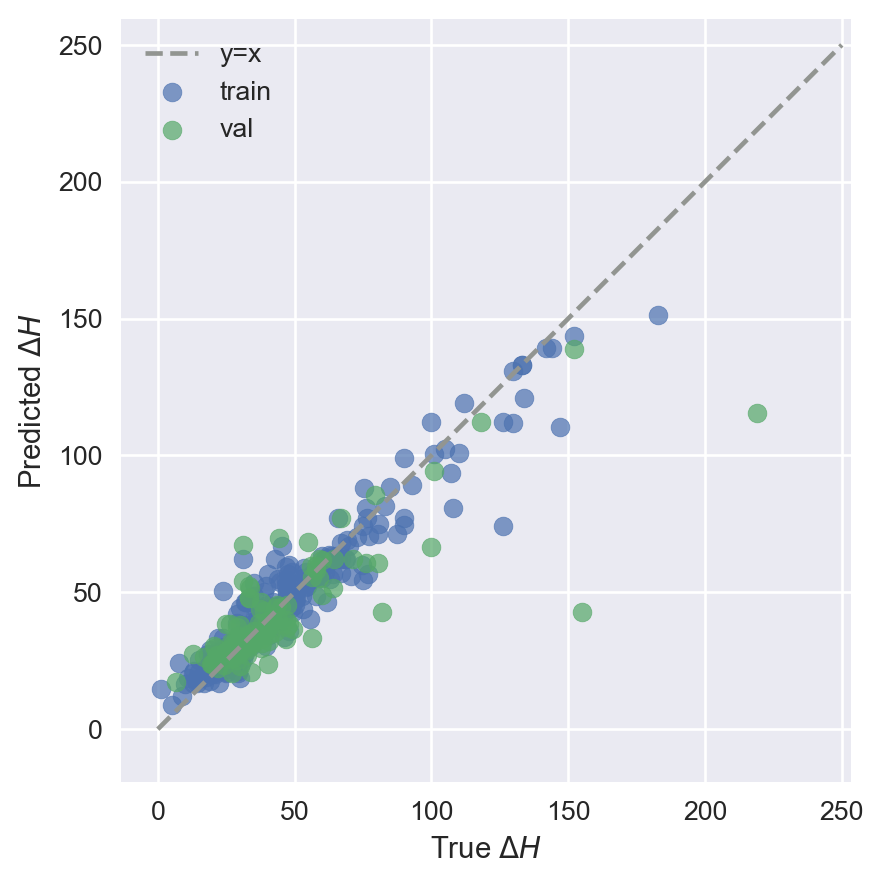

In [11]:
rf_reg.parity_plot(X, y, lim=250)
# print('MAPE: {} ± {}'.format(rf_reg.last_scores['val','mape'].mean(),
#                              rf_reg.last_scores['val','mape'].std()))
plt.savefig('figures/parity_example.png')

# 0.2 Evaluating Many Models <a name="para"></a>
---
[Back to TOC](#contents)

The `Regressor` class enables us to evaluate essentially any object with `.fit()` and `.predict()` methods. Here, we build a dictionary of '{'model name': model instance}' and iterate over it to compare various sklearn models for this dataset.

In [12]:
models_dict = {'rf': ensemble.RandomForestRegressor(),
               'ada': ensemble.AdaBoostRegressor(),
               'knn': neighbors.KNeighborsRegressor(),
               'mlp': neural_network.MLPRegressor(),
               'lin': linear_model.LinearRegression(),
               'huber': linear_model.HuberRegressor(),
               'ridge': linear_model.Ridge(),
               'lasso': linear_model.Lasso()}

results = pd.DataFrame()  # This will be a DataFrame that we keep adding score columns to
for name, mod in models_dict.items():
    print(name)
    reg = Regressor(mod, name=name)  # Make the Regressor
    scores = reg.evaluate(X, y, shuffle=True, n_splits=5).astype(float)  # Evaluate
    scores['name']=name  # Give the results a name
    results = results.append(scores)  # Add the scores dataframe to the results

rf
ada
knn
mlp


/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



lin
huber


/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.

/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



ridge
lasso


### The output of that cell (`results`) is a big dataframe:

In [13]:
results

train                                                     val  \
         mae       mape     medape   pearson  spearman           mae   
0   4.003008  13.900080   4.774194  0.970671  0.942982  1.024223e+01   
1   4.181771  13.641053   5.133779  0.968051  0.937950  8.750081e+00   
2   4.431248  11.653673   5.639541  0.965880  0.945039  7.462707e+00   
3   3.695374   9.755406   4.552949  0.977264  0.961401  8.354811e+00   
4   4.234228  11.288714   6.173016  0.951731  0.939271  1.159086e+01   
0   8.708244  29.165150  19.044182  0.939305  0.677874  1.286484e+01   
1   7.745710  29.688762  14.634146  0.913404  0.747471  1.313415e+01   
2   9.631008  40.536055  19.665014  0.932396  0.680601  1.148639e+01   
3  10.323896  41.206592  22.099717  0.930597  0.727823  1.167193e+01   
4   9.184730  37.901324  17.057850  0.939433  0.705090  9.554836e+00   
0   8.574180  23.652071  11.251029  0.852102  0.846221  1.017206e+01   
1   8.054979  23.238675  10.830450  0.852505  0.848206  9.952367e+00   
2   8.150599  18.568311  10.977707  0.854053  0.849231  1.043306e+01   
3   8.091613  22.176630  10.676657  0.873142  0.847150  9.935685e+00   
4   7.511258  22.860656  11.247543  0.862393  0.858727  1.261267e+01   
0   8.037102  26.707887  13.849586  0.909593  0.769799  1.004206e+01   
1   8.489696  27.290746  13.506132  0.908599  0.744018  1.024436e+01   
2   7.823254  26.452689  13.764113  0.912218  0.766986  1.165199e+01   
3   8.468202  28.141372  13.900559  0.904352  0.748476  1.046101e+01   
4   7.613313  21.007869  13.179990  0.889835  0.750805  1.354261e+01   
0   7.703529  25.907808  13.755469  0.904088  0.794369  1.409372e+01   
1   8.919268  24.516553  16.408917  0.898758  0.768782  1.506658e+01   
2   8.785445  29.886420  15.315729  0.909668  0.761117  1.489864e+01   
3   8.870515  29.980117  15.724742  0.912116  0.766284  2.102477e+01   
4   8.890765  29.675494  16.722694  0.911123  0.787818  6.324553e+13   
0   7.388591  24.336575   9.415548  0.821122  0.824548  1.271022e+01   
1   7.904570  23.452446   9.967681  0.835601  0.822219  9.117862e+00   
2   7.981652  25.838943  10.989943  0.838276  0.828498  1.327025e+01   
3   6.557850  23.426787   9.381732  0.876051  0.803436  1.562066e+01   
4   7.629453  18.213372  10.575605  0.831037  0.786805  1.048145e+01   
0   7.828681  26.096677  12.841468  0.917832  0.793148  1.551818e+01   
1   7.540853  20.173761  13.765058  0.889861  0.803154  1.557802e+01   
2   8.760076  28.373931  14.725781  0.893454  0.761461  1.389017e+01   
3   8.538811  28.219553  14.619801  0.893648  0.789250  1.255240e+01   
4   8.776742  27.721629  14.757742  0.892966  0.800094  1.103579e+01   
0  10.800464  35.808153  18.435722  0.763442  0.653262  1.257187e+01   
1  11.254027  36.969227  17.813553  0.763101  0.616823  1.120330e+01   
2  10.546229  28.177761  16.791312  0.769800  0.637734  1.317672e+01   
3  10.940620  35.347836  19.127382  0.765659  0.667584  1.056814e+01   
4  10.180633  33.258337  16.496453  0.775651  0.664170  1.326783e+01   

                                                 name  
           mape     medape   pearson  spearman         
0  2.675105e+01  16.331579  0.637068  0.712771     rf  
1  2.284562e+01  12.986111  0.833710  0.802774     rf  
2  1.940855e+01  10.552733  0.800250  0.772260     rf  
3  2.886803e+01  10.045619  0.844101  0.802924     rf  
4  4.170662e+01  11.743015  0.703711  0.816275     rf  
0  5.947076e+01  18.298835  0.665811  0.691128    ada  
1  3.229036e+01  17.391849  0.768797  0.625309    ada  
2  3.452250e+01  24.762822  0.742494  0.640015    ada  
3  4.085350e+01  24.393620  0.711268  0.637380    ada  
4  2.914190e+01  20.823997  0.816568  0.670308    ada  
0  2.537010e+01  15.957447  0.762283  0.790601    knn  
1  2.185170e+01  10.921502  0.671177  0.747540    knn  
2  4.582158e+01  15.867804  0.794536  0.734255    knn  
3  2.948322e+01  13.618858  0.660022  0.665594    knn  
4  2.063262e+01  14.395796  0.553688  0.733985    knn  
0  2.443729e+01  18.495229  0.

### We can again use pandas to aggregate all of that

In [14]:
results.groupby('name').mean()

train                                                     val  \
             mae       mape     medape   pearson  spearman           mae   
name                                                                       
ada     9.118717  35.699576  18.500182  0.931027  0.707772  1.174243e+01   
huber   7.492423  23.053625  10.066102  0.840417  0.813101  1.224009e+01   
knn     8.076526  22.099269  10.996677  0.858839  0.849907  1.062117e+01   
lasso  10.744394  33.912263  17.732884  0.767531  0.647915  1.215757e+01   
lin     8.633904  27.993278  15.585510  0.907150  0.775674  1.264911e+13   
mlp     8.086314  25.920112  13.640076  0.904919  0.756017  1.118841e+01   
rf      4.109126  12.047785   5.254696  0.966719  0.945329  9.280138e+00   
ridge   8.289033  26.117110  14.141970  0.897552  0.789421  1.371491e+01   

                                                    
               mape     medape   pearson  spearman  
name                                                
ada    3.925580e+01  21.134225  0.740988  0.652828  
huber  3.180980e+01  15.327200  0.583940  0.676960  
knn    2.863185e+01  14.152281  0.688341  0.734395  
lasso  3.630072e+01  17.264759  0.656357  0.607893  
lin    1.807015e+13  18.762669  0.383947  0.614815  
mlp    3.223683e+01  15.873257  0.770226  0.664135  
rf     2.791598e+01  12.331811  0.763768  0.781401  
ridge  3.735635e+01  17.264670  0.532452  0.627350

### Plot the results

To make the plots in the "figures" folder, I replace `metric` with whatever metric I want to plot (has to be a column from the results dataframe), and change the ylabel as well.

/anaconda/envs/pyTen/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



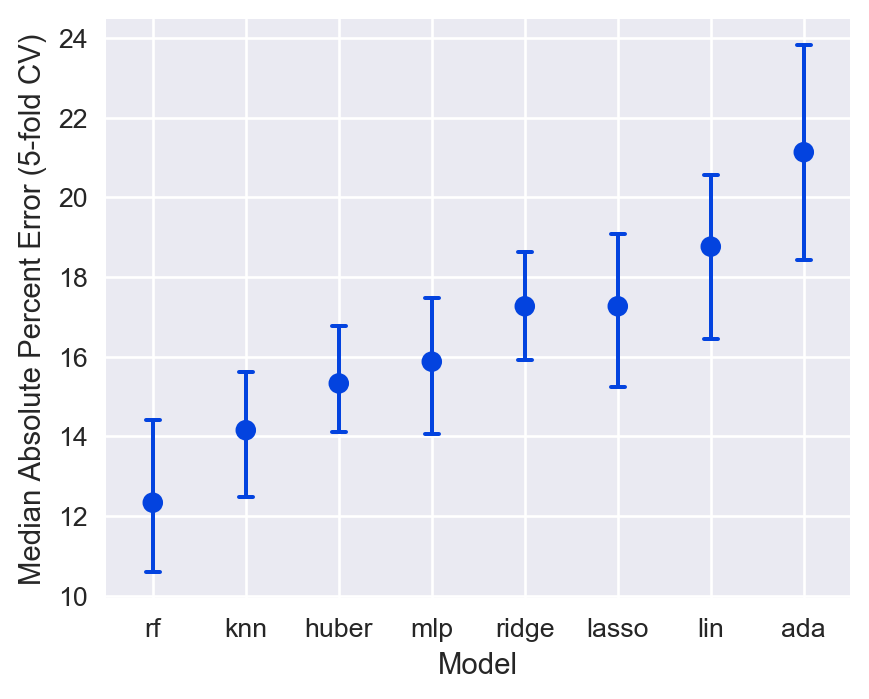

In [15]:
metric = 'medape'

# Plot the models with increasing error
order = results.groupby('name').mean().sort_values(('val',metric), ascending=True).index.values

plt.figure(figsize=(5,4), tight_layout=False)
sns.pointplot('name', ('val',metric), color='xkcd:blue',
              scale=0.75, errwidth=1.5, capsize=0.15,
              join=False, order=order, data=results)
plt.grid(True)
plt.xlabel('Model')
plt.ylabel('Median Absolute Percent Error (5-fold CV)')
plt.savefig('figures/{}_95CI_allmodels.png'.format(metric))

### Random Forest is the best here, followed CLOSELY by KNN regression.

### We can do the same thing again, but with LOGO-CV

In [16]:
results_logo = pd.DataFrame()  # This will be a DataFrame that we keep adding score columns to
for name, mod in models_dict.items():
    print(name)
    reg = Regressor(mod, name=name)  # Make the Regressor
    scores = reg.evaluate(X, y, shuffle=True, n_splits=5, groups=df['Material Class']).astype(float)  # Evaluate
    scores['name']=name  # Give the results_logo a name
    results_logo = results_logo.append(scores)  # Add the scores dataframe to the results_logo

rf
ada
knn
mlp


/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



lin
huber


/anaconda/envs/pyTen/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



ridge
lasso


In [17]:
results_logo.groupby('name').mean()

train                                                  val  \
             mae       mape     medape   pearson  spearman        mae   
name                                                                    
ada     8.963051  34.924797  17.452973  0.934312  0.724006  19.634046   
huber   7.300763  22.588428   8.967572  0.835527  0.826912  31.147798   
knn     7.878434  21.883979  10.767316  0.860634  0.852361  17.402069   
lasso  10.536469  32.902133  17.150766  0.772805  0.660473  17.912163   
lin     8.298708  26.910811  14.531237  0.911434  0.778975  94.145244   
mlp     7.896620  25.211881  12.782674  0.908077  0.772688  20.088929   
rf      4.123103  12.260147   5.188507  0.967506  0.943067  18.941652   
ridge   8.242520  26.124106  13.552299  0.896053  0.790746  35.168169   

                                                  
             mape     medape   pearson  spearman  
name                                              
ada     55.399579  38.114402  0.411003  0.273213  
huber   84.227116  71.592160  0.242046  0.253281  
knn     41.862776  26.179852  0.311326  0.117853  
lasso   47.809029  31.971418  0.464263  0.398533  
lin    203.634247  90.327913  0.228564  0.276499  
mlp     51.628436  41.276548  0.498491  0.284753  
rf      51.263592  28.757221  0.409795  0.232715  
ridge   90.328659  42.956336  0.281520  0.250197

/anaconda/envs/pyTen/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



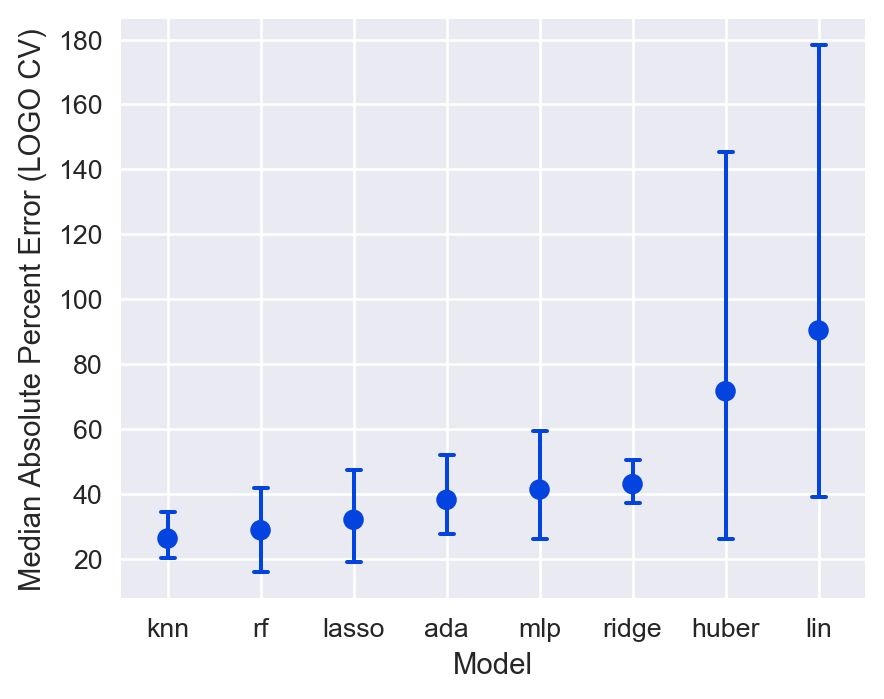

In [18]:
metric = 'medape'

# Plot the models with increasing error
order = results_logo.groupby('name').mean().sort_values(('val',metric), ascending=True).index.values

plt.figure(figsize=(5,4), tight_layout=False)
sns.pointplot('name', ('val',metric), color='xkcd:blue',
              scale=0.75, errwidth=1.5, capsize=0.15,
              join=False, order=order, data=results_logo)
plt.grid(True)
plt.xlabel('Model')
plt.ylabel('Median Absolute Percent Error (LOGO CV)')
plt.savefig('figures/{}_LOGO_95CI_allmodels.png'.format(metric))

### WHOA - KNN is best by a hair in this setting.

# 1. Feature Selection <a name="feats"></a>

## 1.0 Feature Importances <a name="imp"></a>
---
[Back to TOC](#contents)

`Regressor.estimator` will return the `RandomForestRegressor` object from sklearn, which has a `.feature_importances_` attribute. We can combine that with our column names from df to see our feature importances.

In [19]:
df.iloc[10]

Material Class                               A2B
Composition Formula                Mg1.92Al.08Ni
Hydrogen Weight Percent                      3.5
Heat of Formation (kJ/mol H2)               70.5
Temperature (˚C)                             295
Pressure (Atmospheres Absolute)                4
Author Year                         Hirata, 1983
Reference Number                             427
Comment1                                     NaN
Comment2                                     NaN
Comment3                                     NaN
clean_composition                  Mg1.92Al.08Ni
composition                         (Mg, Al, Ni)
Name: 90, dtype: object

In [20]:
rf_imp = pd.DataFrame({'imp': rf_reg.estimator.feature_importances_},
                      index=X.columns)
rf_imp.sort_values('imp', ascending=False)[:15]

,imp
mean NdUnfilled,0.141521
avg_dev Column,0.123327
mean GSvolume_pa,0.107631
mean CovalentRadius,0.096244
minimum NUnfilled,0.047956
mode GSvolume_pa,0.044056
maximum Column,0.041418
mean Electronegativity,0.037075
avg_dev NdUnfilled,0.025128
avg_dev NValence,0.023673


So there are the top 15 "most important" features. Mind you, these values are pulled directly from `Regressor.estimator`, which means they were set by whatever the last call to `.fit()` was. This will either be from the last fold of CV in `.evaluate()`, or from `.parity_plot()`.

### We can make a histogram of the feature importances to see the distribution.

/anaconda/envs/pyTen/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



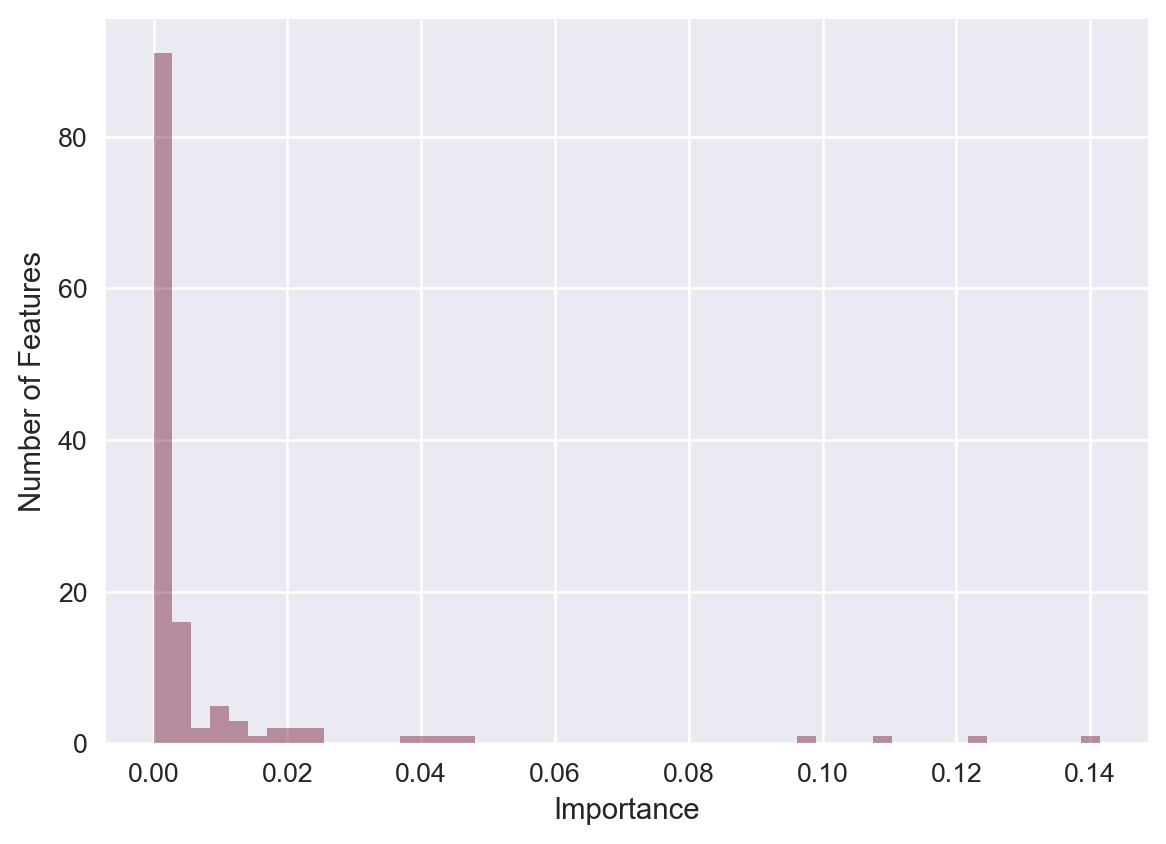

In [21]:
plt.figure(figsize=(7,5), tight_layout=False)
sns.distplot(rf_imp['imp'], color='xkcd:maroon', kde=False)
plt.xlabel('Importance');
plt.ylabel('Number of Features');
plt.savefig('figures/feature_importance_hist.png')

# 1.1 Recursive Feature Elimination <a name="rfe"></a>
---
[Back to TOC](#contents)

RFE uses the feature importances from above to pare down the feature set to the "most important" features. However, sklearn's implementation of this tries to do too much under the hood. With our `Regressor` wrapper, we can code this pretty easily and retrieve meaningful results from the process. The algorithm proceeds as follows:
* Fit model with n features
* Store results of cross validation
* Get feature importances
* Remove feature with lowest importance
* Repeat until only one feature is left

In [22]:
rfe_results = pd.DataFrame()  # Store results of each iteration in a DataFrame
feat_set = X.columns # Start with all features

for n_feats in tqdm(range(len(feat_set),0,-1)):
    
    ### EVALUATE MODEL ###
    scores = rf_reg.evaluate(X[feat_set], y, shuffle=True, n_splits=5).astype(float)  # Evaluate
    scores['n_feats']=n_feats  # Store the number of feats
    
    ### REMOVE LEAST IMPORTANT FEATURE ###
    rf_imp = pd.DataFrame({'feat':feat_set,
                           'imp': rf_reg.estimator.feature_importances_})
    worst_feat = rf_imp.sort_values('imp')['feat'].iloc[0]
    scores['worst_feat'] = worst_feat
    feat_set = [f for f in feat_set if f is not worst_feat]
    
    ### APPEND RESULTS ###
    rfe_results = rfe_results.append(scores)  # Add the scores dataframe to the results

100%|██████████| 132/132 [00:58<00:00,  2.26it/s]


In [23]:
rfe_agg = rfe_results.groupby('n_feats').agg(['mean','std'])
rfe_agg['worst_feat'] = rfe_results.groupby('n_feats').apply(lambda df: df.iloc[0])['worst_feat']
rfe_agg.head()

train                                                      \
              mae                 mape               medape             
             mean       std       mean       std       mean       std   
n_feats                                                                 
1        9.243750  0.313377  27.345118  2.858131  12.671528  0.631126   
2        5.359100  0.382741  15.019858  0.638171   7.639537  0.532342   
3        4.600848  0.193805  13.134627  1.084611   6.233399  0.261325   
4        4.562095  0.214001  12.936820  0.332704   5.776976  0.267623   
5        4.473979  0.193399  12.973731  1.987632   5.997786  0.311893   

                                                        ...           \
          pearson            spearman                   ...            
             mean       std      mean       std         ...            
n_feats                                                 ...            
1        0.836815  0.041449  0.752129  0.012776         ...            
2        0.950259  0.006397  0.906180  0.011268         ...            
3        0.961338  0.008501  0.932832  0.008172         ...            
4        0.952965  0.008660  0.936000  0.009425         ...            
5        0.961481  0.005259  0.940511  0.004098         ...            

              val                                                       \
              mae       mape                medape             pearson   
              std       mean        std       mean       std      mean   
n_feats                                                                  
1        1.356750  42.594648  15.783576  21.741316  2.763743  0.633699   
2        2.307197  30.558511   8.909633  14.786900  2.212722  0.806268   
3        1.896728  31.198641  10.216161  14.137596  2.223413  0.762474   
4        1.817147  30.762985   9.760859  13.682061  1.731068  0.785825   
5        0.953916  30.682334   9.585523  13.175913  0.715081  0.739323   

                                                worst_feat  
                   spearman                                 
              std      mean       std                       
n_feats                                                     
1        0.160446  0.518410  0.045754      mean NdUnfilled  
2        0.047596  0.696438  0.051836       avg_dev Column  
3        0.049229  0.719533  0.042011  mean CovalentRadius  
4        0.044008  0.739432  0.099991     mean GSvolume_pa  
5        0.069979  0.753118  0.035013     avg_dev NValence  

[5 rows x 21 columns]

### Now we can plot these results to see what our "minimal set" of features is

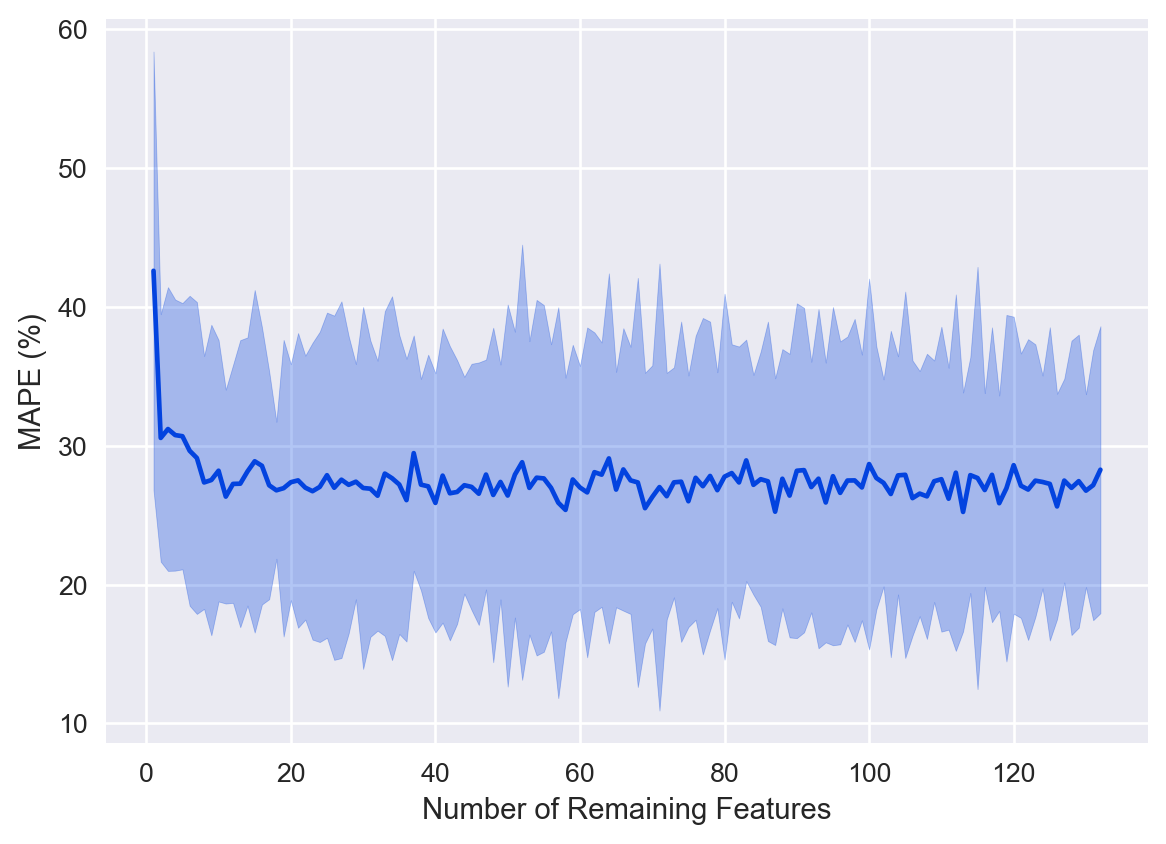

In [24]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=False)
n_feats = rfe_agg.index
means = rfe_agg[('val','mape','mean')]  # Choose whatever metric you want to plot
stds =  rfe_agg[('val','mape', 'std')]

ax.plot(n_feats,means,'-',color='xkcd:blue')
ax.fill_between(n_feats, means-stds, means+stds, color='xkcd:blue', alpha=0.3)
ax.set_xlabel('Number of Remaining Features')
ax.set_ylabel('MAPE (%)')
plt.savefig('figures/Recursive_Feature_Elimination.png')

### This is telling us that we really don't need more than ~12 features to maximize model performance, as long as we pick the right 12. And those 12 are:

In [25]:
rfe_agg['worst_feat'][:12]

n_feats
1             mean NdUnfilled
2              avg_dev Column
3         mean CovalentRadius
4            mean GSvolume_pa
5            avg_dev NValence
6                 mean Column
7          avg_dev NdUnfilled
8         avg_dev GSvolume_pa
9     range Electronegativity
10       avg_dev AtomicWeight
11              mean GSmagmom
12       mean MendeleevNumber
Name: worst_feat, dtype: object

This is interesting. It's not clear exactly why these features are the most important. Maybe more concerning, our model performance doesn't even suffer that much if we only had **4** features. This seems to imply that RandomForest is acting more like a nearest-neighbor lookup, which explains why KNN regression was so close in performance.

## 1.2 Random Feature Elimination <a name="rand"></a>
---
[Back to TOC](#contents)

### Here, we evalute RandomForest with randomly constrained subsets of our features. This is an attempt to see how invariant RF performance is to the particular set of limited features used for evaluation.

Note that this contrasts with the "bootstrapping" performed internally; by default, a [RandomForestRegressor](https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/ensemble/forest.py#L103) fits each individual tree by sampling X.shape[0] samples from X *with replacement*. So the number of observations (rows) used to fit each tree is the same as the full dataset, but some points are duplicated and some are eliminated.

Here, we are sub-sampling the *features (columns)* of X to answer the question **"How many features are actually needed to optimize the predictive power of our model?"** We randomly sample (without replacement) n features where n varies from 3 to the total number of features, and repeat this process `num_reps` times for each `n` to get error bars.

In [26]:
cols_fs = ['num_feats', 'feat_list', 'mape_mean', 'mape_std']  # fs = feature selection
df_fs = pd.DataFrame(columns=cols_fs)

num_reps = 15

for n_feats in tqdm(range(3,X.shape[1]+1)):
    for rep in range(num_reps):
        X_subset = X.sample(n_feats, axis=1)
        scores_i = rf_reg.evaluate(X_subset, y, n_splits=3)
        res_list = [n_feats, X_subset.columns,
                    scores_i['val','mape'].mean(),
                    scores_i['val','mape'].std()]
        res_dict = {k:v for k,v in zip(cols_fs, res_list)}
        df_fs = df_fs.append(res_dict, ignore_index=True)

100%|██████████| 130/130 [05:48<00:00,  4.21s/it]


A few example results look like this:

In [27]:
df_fs.sample(4)

,num_feats,feat_list,mape_mean,mape_std
297,22,"Index(['avg_dev NsUnfilled', 'maximum NfUnfill...",30.374036,6.887788
1733,118,"Index(['mean NValence', 'minimum NUnfilled', '...",27.831813,10.304196
1147,79,"Index(['maximum NdValence', 'mode Number', 'av...",28.544568,6.804245
833,58,"Index(['minimum NsUnfilled', 'mean GSbandgap',...",28.175714,9.873705


We have:
* **num_feats**: the number of sub-sampled features
* **feat_list**: the list of sub-sampled features
* **mape_mean**: mean MAPE over however many folds of CV (I think 3 here)
* **mape_std** std dev of MAPE over the same

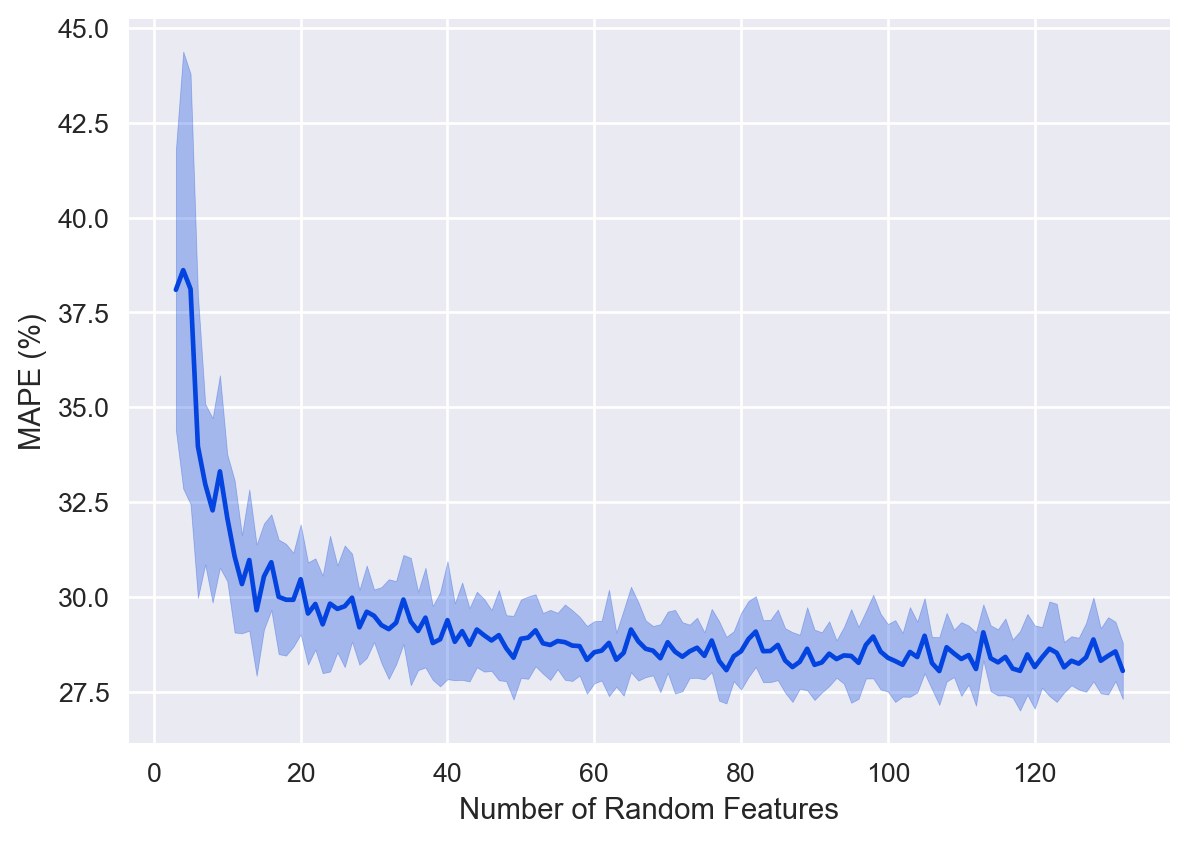

In [28]:
plt.figure(figsize=(7,5), tight_layout=False)
ax=plt.gca()
n_feats = df_fs.groupby('num_feats').count().index.values
means = df_fs.groupby('num_feats').mean()['mape_mean']
stds = df_fs.groupby('num_feats').std()['mape_mean']

ax.plot(n_feats,means,'-',color='xkcd:blue')
ax.fill_between(n_feats, means-stds, means+stds, color='xkcd:blue', alpha=0.3)
ax.set_xlabel('Number of Random Features')
ax.set_ylabel('MAPE (%)')
plt.savefig(f'figures/Random_Feature_Elimination_{num_reps}reps.png')

### From this graph we can see that performance stabilizes at about 30 features.

Note that the error bars here are standard deviations over the num_reps sets of randomly selected features, not over cross validation, as they were for the recursive elimination plot.

### So this was the initial attempt at quantifying feature selection for this particular regression task.

However, this approach is broadly applicable to any regression problem.

# 2. Hyperparameter Optimization <a name="hypes"></a>
---
[Back to TOC](#contents)

This will provide a brief overview of the `.optimize_hyperparameters()` method for the `Regressor` class. It uses the nevergrad library from Facebook Research for mixed continuous/discrete optimization.

The only tricky part is that you must pass in ["instrumented" arguments](https://github.com/facebookresearch/nevergrad/blob/master/docs/instrumentation.md) for the sklearn estimator class that you're using. An instrumented argument knows whether it is continuous (instru.variables.Gaussian), "ordered discrete" (see below), or categorical (instru.variables.SoftmaxCategorical), and contains the range or list of values over which it should be optimized.

So for 'n_estimators', for example, it must be an integer, so we provide `list(range(5,200,5))`, so it will consider values from 5 to 200 with steps of 5. Then we just hit go, and everything else is taken care of under the hood.

The result will be returned, but also stored inside the `Regressor` object as `Regressor.best_hypes`, which can be fed directly as a `**kwargs` for evaluation or parity plotting.

In [29]:
from nevergrad import instrumentation as instru

rf_reg2 = Regressor(ensemble.RandomForestRegressor(), name='Random Forest')

# hype_dict needs to have
# 'name of estimator kwarg': instrumented nevergrad variable
hype_dict = {'n_estimators': instru.variables.OrderedDiscrete(list(range(5,200,5))),
             'max_depth': instru.variables.OrderedDiscrete(list(range(2,30,1))),
             'min_samples_leaf': instru.variables.OrderedDiscrete(list(range(1,9,1)))
            }

# Ok, let's optimize! Pass the hype_dict, X, y, and a metric to use.
rf_reg2.optimize_hyperparameters(hype_dict, X, y, metric='mape')

Recommended hyperparameters:  {'n_estimators': 195, 'max_depth': 29, 'min_samples_leaf': 2}


{'max_depth': 29, 'min_samples_leaf': 2, 'n_estimators': 195}

Note the recommended hyperparameters, which fall somewhere in the middle of the provided ranges. We can now pass these to the `.evaluate()` method and see the results.

In [30]:
scores_opt = rf_reg2.evaluate(X, y, hypes=rf_reg2.best_hypes)
scores_opt.agg(['mean','std'])

train                                                val             \
           mae       mape    medape   pearson  spearman       mae       mape   
mean  4.282836  13.081159  5.254126  0.949288  0.948131  8.897032  26.884456   
std   0.230924   1.343028  0.282592  0.007044  0.006069  2.278902  10.724997   

                                     
         medape   pearson  spearman  
mean  11.330470  0.799745  0.802328  
std    1.289681  0.072452  0.018770

MAPE: 26.88445612144315 ± 10.724997239640881


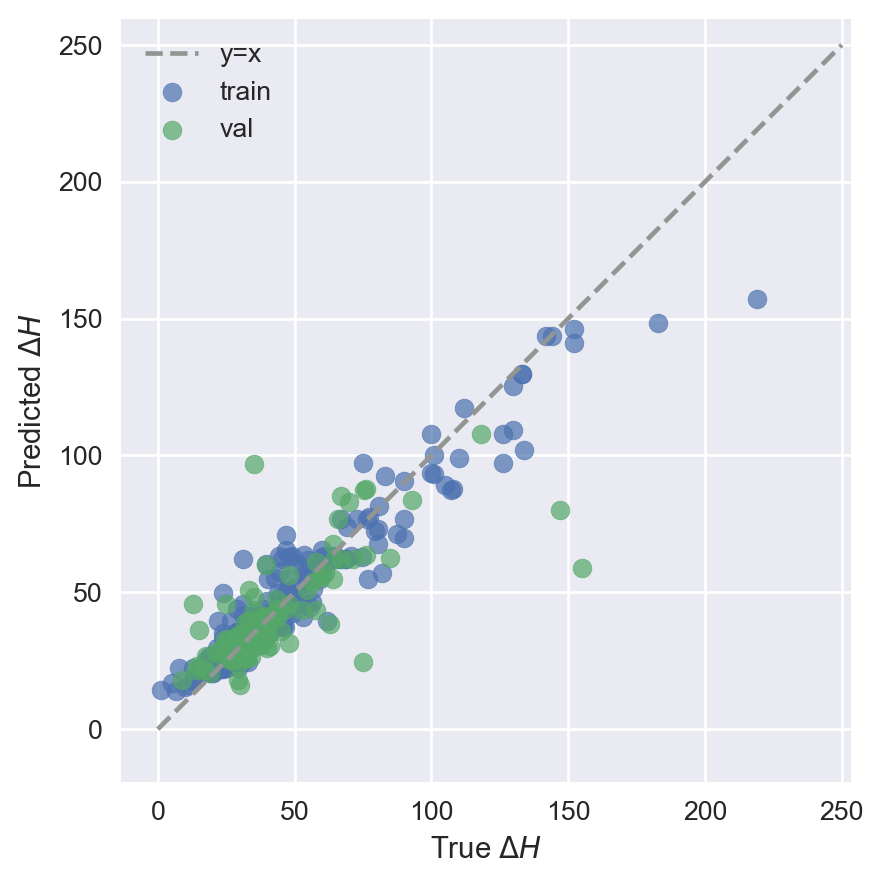

In [31]:
rf_reg2.parity_plot(X, y, hypes='best', lim=250)
print('MAPE: {} ± {}'.format(rf_reg2.last_scores['val','mape'].mean(),
                             rf_reg2.last_scores['val','mape'].std()))
plt.savefig('figures/parity_example.png')

So that looks to have improved insignificantly (MAPE is still ~27%). In general it did not seem like hyperparameter optimization was a large factor for this dataset for any of the models tested. However, this approach is general, and somewhat more flexible (and theoretically faster) than a gridsearch.

### That's the end of the notebook!